In [ ]:
'''NOTES
==================
- We compare the Hagan Approximation for swaption pricing under the CEV Model with the closed form Chi-Square pricer
- To do so, we simulate possible values of the power coefficient Beta and the volatility coefficient Sigma
- We repeat this exercise for different tenors and maturities

- This involves constructing a pricing yield curve and the pricers explicitly. 
- We compare different curve fitting techniques and observe that there is little difference for many of the curves with 
    the exception of the Nelson Siegel Svensson.
- We use the curve to construct the pricers and find the percentage error between them. (The reference being the Chi_Square
    pricer.)
- We the finally plot the results.'''

In [9]:
%%capture
%pylab inline --no-import-all
import numpy as np
import pandas as pd
import os
from math import *
import pandas as pd
from scipy import stats, optimize
from QuantLib import *
import matplotlib
import matplotlib.pyplot as plt
import utils
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve, calibrate
from datetime import datetime

import base64
import itertools
from IPython.display import HTML, display
import tabulate
import zipfile

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

import seaborn as sb

import time
import datetime

eval_date = Date.todaysDate()
Settings.instance().setEvaluationDate(eval_date)

In [10]:
'''OBTAIN YIELD CURVE DATA (EONIA RATES)'''
'''These rates will be used for OIS Discounting in swaption pricing'''
loc = "Data/Calibration Data.xlsx"
df = pd.read_excel(loc, 
                   sheet_name = "EONIA Rates",
                   skiprows= [0, 1,3],
                   index_col = "Dates")
df = pd.DataFrame.dropna(df, axis = 'rows')

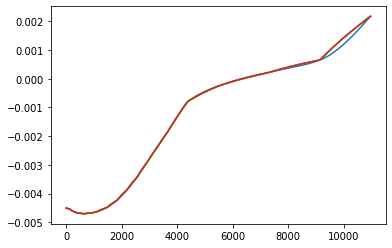

In [11]:
'''CONSTRUCTION OF THE OIS DISCOUNT CURVE'''
#Input market quotes
'''SHORT EONIA RATES: 1Day - 4 WEEKS MATURITY'''
SE_Mat = ([Period(1, Weeks), 
          Period(2, Weeks), 
          Period(3, Weeks), 
          Period(4, Weeks)] + 
            [Period(i, Months) for i in range(2, 24)] +  
            [Period(2, Years), Period(30, Months)] +
            [Period(i, Years) for i in range(3, 13)]+
            [Period(15, Years), Period(20, Years), Period(25, Years), Period(30, Years)])

SE_Mat_Rates = df.loc['2020-01-27']

## EONIA Rate Helpers
'''We create rate helpers based on the definition of the OIS contract on Bloomberg'''
helpers = [OISRateHelper(2, #Settlement Days 
              tenor, #Tenor of the OIS 
              QuoteHandle(SimpleQuote(rate/100)), #OIS Rate
              Eonia())
for rate, tenor in zip(SE_Mat_Rates, SE_Mat)]

## Construct EONIA Curve
eonia_curve = PiecewiseLogLinearDiscount(0, 
                                       TARGET(),
                                       helpers,
                                       Actual365Fixed())

eonia_curve_ff = PiecewiseFlatForward(0, 
                            TARGET(),
                            helpers, 
                            Actual365Fixed())

eonia_curve_cz = PiecewiseCubicZero(0, 
                            TARGET(),
                            helpers, 
                            Actual365Fixed())

eonia_curve_ld = PiecewiseLogLinearDiscount(0, 
                            TARGET(),
                            helpers, 
                            Actual365Fixed())

#Plotting the curve
today = eonia_curve_ff.referenceDate()
end = today + Period(30,Years)
dates = [ Date(serial) for serial in range(today.serialNumber(),
end.serialNumber()+1) ]

rates_c = [eonia_curve_cz.zeroRate(TARGET().advance(d,1,Days),
Actual360(), Simple).rate()
for d in dates ]

rates_ff = [eonia_curve_ff.zeroRate(TARGET().advance(d,1,Days),
Actual360(), Simple).rate()
for d in dates ]

rates = [eonia_curve.zeroRate(TARGET().advance(d,1,Days),
Actual360(), Simple).rate()
for d in dates ]

rates_ld = [eonia_curve_ld.zeroRate(TARGET().advance(d,1,Days),
Actual360(), Simple).rate()
for d in dates ]

plt.plot(rates_c)
plt.plot(rates_ff)
plt.plot(rates)
plt.plot(rates_ld)

In [12]:
def sigma_CEV_Hagan(S0, K,sigma, beta, eval_date, expiry):
    Sav = (S0+K)/2
    theta = S0 - K
    delta = ((sigma * (Sav**beta))**2)*Actual365Fixed().yearFraction(eval_date, expiry)
    
    term1 = sigma/(pow(Sav, 1 - beta))
    term2 = (pow(1 - beta, 2)*delta)/ (24 * pow(Sav,2))
    term3 = (1 - beta)*(2 + beta)*(pow(theta, 2)/(24 *pow(Sav,2)))
    term4 = (pow(1 - beta,2)*pow(delta,2))/((1920 *pow(Sav,4))*(7 - 54*beta + 27*pow(beta,2)))
    term5 = (pow(1 - beta,2)*pow(delta,2))/(2880 *pow(Sav,4))*(29 - 13*beta - 16*pow(beta,2))
    term6 = (1 - beta)*(delta**4)/((5760 *pow(Sav,4))*(72 - 34*beta - 9*pow(beta,2) - 7*pow(beta,3)))
    
    sigma_black = term1 * (1 + term2 + term3 + term4 + term5 + term6)
    
    return(sigma_black)

In [13]:
def payer_Black(N, S0, expiry, tenor, K, sigma):
    schedule = Schedule(expiry,
         tenor,
         Period(Annual),
         TARGET(),
         ModifiedFollowing,
         ModifiedFollowing,
         DateGeneration.Forward,
         False)
    PVBP = np.sum([eonia_curve_ld.discount(date) for date in np.array(list(schedule)[1:])])
    T = Actual365Fixed().yearFraction(eval_date, expiry)
    d1 = (log(S0/K) + 0.5*(pow(sigma,2)*T))/(sigma * sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    price = N*PVBP * (S0*stats.norm.cdf(d1) - K*stats.norm.cdf(d2))
    return(price)

In [14]:
def payer_chi_square(N, S0, expiry, tenor, K, beta, sigma):
    schedule = Schedule(expiry,
         tenor,
         Period(Annual),
         TARGET(),
         ModifiedFollowing,
         ModifiedFollowing,
         DateGeneration.Forward,
         False)
    
    PVBP = np.sum([eonia_curve_ld.discount(date) for date in np.array(list(schedule)[1:])]) 
    
    d = (pow(K,2 - 2*beta)/(pow(1 - beta,2)*pow(sigma,2)*
                            (Actual365Fixed().yearFraction(eval_date, tenor))))
    b = 1/(1 - beta)
    f = (pow(S0, 2 - 2*beta)/(pow(1 - beta, 2)*pow(sigma, 2)*
                              (Actual365Fixed().yearFraction(eval_date, tenor))))
    price = N * PVBP * (S0*(1 - stats.ncx2.cdf(d, b+2, f)) - K*(stats.ncx2.cdf(f, b, d)))
    return(price)

In [15]:
'''VECTORIZE FUNCTIONS'''
Hagan_vect = np.vectorize(sigma_CEV_Hagan)
Black_vect =np.vectorize(payer_Black)
Chi_vect = np.vectorize(payer_chi_square)

In [16]:
class SensitivityTesting:
    '''We define a class that allows us to perform sensitivity tests on both the chi square and Hagan approximation
    pricers.
    
    To do this, we define a vector of betas, sigmas, tenors and maturities. We then compare the %error obtained for
    each scenario.
    
    This provides us with a rich amount of data enabling us to have a proper vision of the weaknesses of the Hagan 
    approximation or points where the Chi Square pricer produces explosive results
    
    CLASS METHODS
    ==============
    1) scenario_run: Runs all the scenarios and finds the pricing error for each
    2) plot_scenario: For each beta and sigma value, a heatmap of the error is plotted
    3) save_results_txt: Saves results in a Text File
    4) beta_sigma_3D_sample: Plots a 3D sample of the interaction between the Sigma & Beta terms
    5) beta_sigma_heatmap: Heatmap of the average error per sigma/beta tuple
    
    NOTES
    =============
    -Be sure to run the scenario_run function before proceeding to plot the graphs.
    -The scenario run provides the data required for the plots'''
    
    parameters = np.array([])
    hagan_price = np.array([])
    chi_square_price = np.array([])
    results_pd = pd.DataFrame(columns = ["Beta","Sigma", "Maturity", "Tenor", "Error"] )
    
    def __init__(self, S0, K, Beta, Sigma, Tenor, Expiry, beta_test = 0.1, sigma_test = 0.001):
        self.S0 = S0
        self.K = K
        self.Beta = Beta
        self.Sigma = Sigma
        self.Tenor = Tenor
        self.Expiry = Expiry 
        self.beta_test = beta_test
        self.sigma_test = sigma_test
     
    def scenario_run(self):
        S0, K, Beta, Sigma, Tenor, Expiry = self.S0, self.K, self.Beta, self.Sigma, self.Tenor, self.Expiry
        time_start = time.time()
        Dates = [[i, j] for i, j in itertools.product(*[Expiry, Tenor]) if i < j]
        test = list(itertools.product(*[Beta,Sigma]))
        test2 = list(itertools.product(*[test,Dates]))
        self.parameters = np.matrix([[item[0][0], item[0][1], item[1][0], item[1][1]] for item in test2])
        vol = Hagan_vect(S0, K, self.parameters[:,1], self.parameters[:,0], eval_date, self.parameters[:,2])
        self.hagan_price = Black_vect(N, S0, self.parameters[:,2], self.parameters[:,3], K, vol)
        self.chi_square_price = Chi_vect(N, S0, self.parameters[:,2], self.parameters[:,3], K, 
                                         self.parameters[:,0], self.parameters[:,1])
        error = np.round((np.array(self.hagan_price)/np.array(self.chi_square_price) -1)*100, 1)
        results = np.c_[self.parameters, error]
        self.results_pd = pd.DataFrame(results, columns = ["Beta","Sigma", "Maturity", "Tenor", "Error"])
        self.results_pd.Tenor = np.array([round(Actual365Fixed().yearFraction(maturity,maturity2),0) 
                                          for maturity, maturity2 in zip(self.results_pd.Maturity, self.results_pd.Tenor)])
        self.results_pd.Maturity = np.array([round(Actual365Fixed().yearFraction(eval_date,maturity), 0) for
                                             maturity in self.results_pd.Maturity])
        time_end = time.time()
        print('Scenario Run completed. Run Time: '+ str((time_end - time_start)/60) + ' minutes')


    def plot_scenario(self, beta_test, sigma_test):
        sigma_vec = np.array(self.results_pd.Sigma == sigma_test)
        beta_vec = np.array(self.results_pd.Beta == beta_test)
        shock_vec = np.logical_and(sigma_vec, beta_vec)
        res_shock_sigma = self.results_pd[shock_vec]
        fig3 = go.Figure(data = go.Heatmap(z = res_shock_sigma["Error"] ,
                                          x = res_shock_sigma["Maturity"] ,
                                          y = res_shock_sigma["Tenor"],
                                          colorbar=dict(title='Error (%)'),
                                            colorscale='YlOrRd'))
        fig3.update_layout(
            title={
                'text': 'Error(%) {Sigma = ' + str(sigma_test) + '; Beta ='+ str(beta_test) + '}',
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'},
            xaxis_nticks=36,
            yaxis_nticks=20,
            xaxis_title="Maturity (Years)",
            yaxis_title="Tenor (Years)",
            font=dict(
                family="Open Sans",
                size=14,
                color="yellow"),
             template = "plotly_dark")
        fig3.show()
        
    def save_results_txt(self, location):
        results  = pd.DataFrame.to_numpy(self.results_pd)
        np.savetxt(location,results)
        
    def beta_sigma_3D_sample(self, num_points = 100):
        full_data_sample = self.results_pd.sample(num_points)
        fig3D = px.scatter_3d(full_data_sample, 
                     x = 'Beta',
                     y = 'Sigma',
                     z = 'Error',
                     size_max=5,
                     opacity = 0.8)
        
        fig3D.update_layout(width=700, 
                            height=700, 
                            title = 'Beta - Sigma Comparison',
                  scene = dict(xaxis=dict(title='Beta', titlefont_color='white'),
                               yaxis=dict(title='Sigma', titlefont_color='white'),
                               zaxis=dict(title='Error', titlefont_color='white'),
                               bgcolor = 'rgb(20, 24, 54)'
                           ))
        fig3D.show()
      
    def beta_sigma_heatmap(self):
        summary = self.results_pd.groupby(['Beta', 'Sigma'])['Error'].sum()
        count = self.results_pd.groupby(['Beta', 'Sigma'])['Error'].count()
        summary = summary/count
        summary = summary.reset_index()
        summary = summary[summary.Error > -1000]
        summary = summary[summary.Error < 1000]
        
        fig = go.Figure(data = go.Heatmap(z = summary["Error"] ,
                                      x = summary["Beta"] ,
                                      y = summary["Sigma"],
                                      colorbar=dict(title='Error (%)'),
                                        colorscale='YlOrRd'))
        fig.update_layout(
            title={
                'text': 'Mean Error - Sigma vs Beta',
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'},
            xaxis_nticks=36,
            yaxis_nticks=20,
            xaxis_title="Beta",
            yaxis_title="Sigma",
            font=dict(
                family="Open Sans",
                size=14,
                color="yellow"),
             template = "plotly_dark")
        fig.show()

In [19]:
'''TESTING THE CLASS OBJECT'''
# We set the parameters
N = 1e+5
S0 = 0.035
K = 0.035

Beta = [i/50 for i in range(1, 50)]
Sigma = [i/1000 for i in range(1, 30)]
Expiry = [Date(30, 1, (2020+i)) for i in range(1, 30)]                                                                                                                                        
Tenor = [Date(30, 1, (2020+i)) for i in range(2, 31)] 

# We build the class
sensi1 = SensitivityTesting(S0, K, Beta, Sigma, Tenor, Expiry)

# Run the scenario
sensi1.scenario_run()

Scenario Run completed. Run Time: 6.452904887994131 minutes


In [ ]:
'''PLOTS'''
'''1) Scenario plots'''
sensi1.plot_scenario(0.1, 0.005)

In [ ]:
'''ANNEX CODE'''
'''All the tests were conducted in this section. If there is a section of code that does not work, please feel free to 
test it here.'''
"1) SET PARAMETERS"
N = 1e+5
S0 = 0.07
K = 0.045

Beta = [i/100 for i in range(1, 100)]
Sigma = [i/10000 for i in range(1, 200)]
Expiry = [Date(30, 1, (2020+i)) for i in range(1, 30)]                                                                                                                                        
Tenor = [Date(30, 1, (2020+i)) for i in range(2, 31)] 

"2) COMBINE PARAMETERS INTO A SINGLE MATRIX"
eval_date = Date.todaysDate()
expiry = Date(30, 1, 2022)
Dates = [[i, j] for i, j in itertools.product(*[Expiry, Tenor]) if i < j]

test = list(itertools.product(*[Beta,Sigma]))
test2 = list(itertools.product(*[test,Dates]))
parameters = np.matrix([[item[0][0], item[0][1], item[1][0], item[1][1]] for item in test2])

"3) VECTORIZE OUR FUNCTIONS"
parameters = np.array([])
hagan_price = np.array([])
chi_square_price = np.array([])

Hagan_vect = np.vectorize(sigma_CEV_Hagan)
Black_vect =np.vectorize(payer_Black)
Chi_vect = np.vectorize(payer_chi_square)

#After running the simulation we join the parameter data to the error data to obtain the full data
# The simulation step is what we are trying to optimize in this case
error = ((hagan_price/chi_square_price)-1)*100
full_data = np.column_stack((parameters,error))

"4) CHECK THE NUMBER OF AVAILABLE PROCESSORS"







'''5)HEATMAP BETA VS SIGMA - MEAN ERROR'''
'''We plot a heatmap comparing the size of the error for each Beta, Sigma combination'''
summary = pd.DataFrame(full_data, columns = ['Beta', 'Sigma','Maturity','Tenor','Error']).groupby(['Beta', 'Sigma'])
test = round(summary.sum()/435, 0)
test2 = test.reset_index()
test2 = test2[test2.Error > -1000]

# Plotting the Heatmap
fig3 = go.Figure(data = go.Heatmap(z = test2["Error"] ,
                                      x = test2["Beta"] ,
                                      y = test2["Sigma"],
                                      colorbar=dict(title='Error (%)'),
                                        colorscale='YlOrRd'))
fig3.update_layout(
    title={
        'text': 'Mean Error - Sigma vs Beta',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_nticks=36,
    yaxis_nticks=20,
    xaxis_title="Beta",
    yaxis_title="Sigma",
    font=dict(
        family="Open Sans",
        size=14,
        color="yellow"),
     template = "plotly_dark")
fig3.show()


'''6) SAMPLE 3D FIGURE - BETA vs SIGMA'''
full_data_sample = pd.DataFrame(full_data[np.random.randint(0,len(full_data),10000)],
                                columns = ['Beta', 'Sigma','Maturity','Tenor','Error'])

fig3D = px.scatter_3d(full_data_sample, 
                     x = 'Beta',
                     y = 'Sigma',
                     z = 'Error',
                     size_max=1,
                     opacity = 0.8,
                     color = 'Tenor')

fig3D.update_layout( title={
        'text': 'Mean Error - Sigma vs Beta',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
        family="Open Sans",
        size=14,
        color="black"),
     template = "plotly")
fig3D.show()